# Build Question answering system on annual report of Apple 

 - Inspired by haystack article - but the below demo is not using Haystack due to installation issue
 - Built using separate components to open the black box


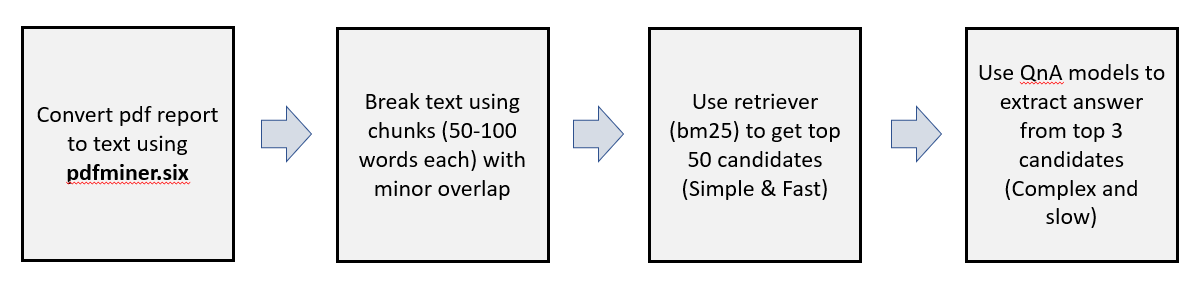

In [ ]:
# Install some libraries

!pip install pdfminer.six rank_bm25 termcolor


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_colwidth=-1
pd.options.display.min_rows=100
import re
from rank_bm25 import BM25Okapi
import string 
from sklearn.feature_extraction import _stop_words
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification

import pdfminer
from pdfminer.high_level import extract_text
from termcolor import colored
import spacy
import matplotlib.pyplot as plt
import os


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/annual-reports/NASDAQ_MSFT_2020.pdf
/kaggle/input/annual-reports/ASX_CWN_2021.pdf
/kaggle/input/annual-reports/annual-report-adidas-ar20.pdf
/kaggle/input/annual-reports/NYSE_MCD_2020.pdf
/kaggle/input/annual-reports/ASX_DMP_2021.pdf
/kaggle/input/annual-reports/NASDAQ_AAPL_2020.pdf
/kaggle/input/annual-reports/NASDAQ_CZR_2020.pdf


# Read annual report from pdf to text using pdfminer 

In [4]:
text = extract_text('../input/annual-reports/NASDAQ_AAPL_2020.pdf')


In [5]:
# Check sample output 
print(len(text))
text[:1000]

394911


'UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\n☒    ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended September\xa026, 2020\nor\n☐    TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 to \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0.\n\nCommission File Number: 001-36743\n\nApple Inc.\n\n(Exact name of Registrant as specified in its charter)\n\nCalifornia\n\n(State or other jurisdiction\nof incorporation or organization)\n\nOne Apple Park Way\nCupertino, California\n\n(Address of principal executive offices)\n\n94-2404110\n\n(I.R.S. Employer Identification No.)\n\n95014\n\n(Zip Code)\n\n(408) 996-1010\n(Registrant’s telephone number, including area code)\n\nSecurities registered pursuant to Section 12(b) of the Act:\n\nTitle of each class\nCommon S

In [6]:
#help(re.sub)
text = re.sub('\n{1,}', '. ', text)
text = re.sub("\s{1,}", " ", text)
text[:1000]

'UNITED STATES. SECURITIES AND EXCHANGE COMMISSION. Washington, D.C. 20549. FORM 10-K. (Mark One). ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934. For the fiscal year ended September 26, 2020. or. ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934. For the transition period from to .. Commission File Number: 001-36743. Apple Inc.. (Exact name of Registrant as specified in its charter). California. (State or other jurisdiction. of incorporation or organization). One Apple Park Way. Cupertino, California. (Address of principal executive offices). 94-2404110. (I.R.S. Employer Identification No.). 95014. (Zip Code). (408) 996-1010. (Registrant’s telephone number, including area code). Securities registered pursuant to Section 12(b) of the Act:. Title of each class. Common Stock, $0.00001 par value per share. 1.000% Notes due 2022. 1.375% Notes due 2024. 0.000% Notes due 2025. 0.875% Notes due 2025. 1.625% Notes

# Load spacy model

In [7]:
nlp_spacy = spacy.load("en_core_web_sm")


# Use spacy to break into sentences

In [8]:
doc = nlp_spacy(text)
sentences_annual_report = []
for sent in doc.sents:
    if len(sent.text.split()) > 6:
        sentences_annual_report.append(sent.text)
    
f"Total sentences: {len(sentences_annual_report)}"

'Total sentences: 3311'

In [9]:
sentences_annual_report[:10]

['☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934.',
 'For the fiscal year ended September 26, 2020.',
 '☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934.',
 'For the transition period from to .. Commission File Number: 001-36743.',
 'Apple Inc.. (Exact name of Registrant as specified in its charter).',
 'Securities registered pursuant to Section 12(b) of the Act:.',
 'Common Stock, $0.00001 par value per share.',
 'Name of each exchange on which registered.',
 'Securities registered pursuant to Section 12(g) of the Act: None.',
 'Indicate by check mark if the Registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.. Indicate by check mark if the Registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act..']

# Run <b>sentiment analysis</b> to find the top +ve and top -ve statements

- Finbert-tone model is the FinBERT model fine-tuned on 10,000 manually annotated (positive, negative, neutral) sentences from analyst reports (https://huggingface.co/yiyanghkust/finbert-tone)
- FinBERT is a BERT model pre-trained on financial communication text. The purpose is to enhance financial NLP research and practice. It is trained on the following three financial communication corpus. The total corpora size is 4.9B tokens. Corporate Reports 10-K & 10-Q: 2.5B tokens. Earnings Call Transcripts: 1.3B tokens. Analyst Reports: 1.1B tokens

In [10]:
# Load FinBert pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)


Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

In [11]:
# Examples

sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results = nlp(sentences)

for x, y in zip(sentences, results):
    print(x)
    print(y)
    print("\n")
#print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


there is a shortage of capital, and we need extra financing
{'label': 'negative', 'score': 0.9966173768043518}


growth is strong and we have plenty of liquidity
{'label': 'positive', 'score': 1.0}


there are doubts about our finances
{'label': 'negative', 'score': 0.9999710321426392}


profits are flat
{'label': 'neutral', 'score': 0.9889442920684814}




- Run Sentiment Analysis pipeline on Annual report

In [12]:

results = nlp(sentences_annual_report)

sentiment = pd.DataFrame({"docs": sentences_annual_report,
                          "label": [r["label"] for r in results],
                          "score":[r["score"] for r in results]})


<AxesSubplot:>

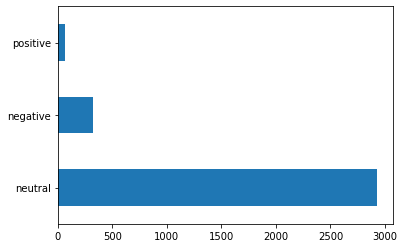

In [13]:
sentiment.label.value_counts().plot(kind="barh")

# Top positive statements in Annual report

In [14]:
display(sentiment[sentiment.label == "positive"].sort_values("score",ascending=False).head(20))


,docs,label,score
289,"resellers’ stores with Company employees and contractors, and improving product placement displays.",positive,1.000000
585,"The Company has a large, global business, and the Company believes that it generally benefits from growth in international .",positive,1.000000
108,"features), relative price and performance, product and service quality and reliability, design innovation, a strong third-party . software and accessories ecosystem, marketing and distribution capability, service and support, and corporate reputation.. Apple Inc.",positive,0.999999
272,"customer demand for new and upgraded products and services, and successfully manage the transition to these new and . upgraded products and services.",positive,0.999995
336,"arrangements can lower operating costs, they also reduce the Company’s direct control over production and distribution.",positive,0.999994
700,will effectively limit its credit risk and avoid losses..,positive,0.999993
851,The strength of the Japanese yen relative to the U.S. dollar had a favorable .,positive,0.999978
810,"Total net sales increased 6% or $14.3 billion during 2020 compared to 2019, primarily driven by higher net sales of Services and .",positive,0.999976
1066,minimizing the potential risk of principal loss.,positive,0.999974
826,"Mac net sales increased during 2020 compared to 2019 due primarily to higher net sales of MacBook Pro.. iPad net sales increased during 2020 compared to 2019 due primarily to higher net sales of 10-inch versions of iPad, iPad Air .",positive,0.999972


# Top Negative statements in Annual report

In [15]:
display(sentiment[sentiment.label == "negative"].sort_values("score",ascending=False).head(20))


,docs,label,score
376,"services, delay in new product and service introductions and lost sales..",negative,0.999999
375,"to the Company’s reputation, loss of competitive advantage, poor market acceptance, reduced demand for products and .",negative,0.999999
497,"Due to the high cost structure associated with the Company’s retail stores, a decline in sales or the closure or poor .",negative,0.999999
230,new debt; reduced liquidity; and declines in the fair value of the Company’s financial instruments.,negative,0.999999
198,"provided by outsourcing partners, resulting in temporary iPhone supply shortages that affected sales worldwide.",negative,0.999998
601,Political uncertainty surrounding international trade disputes could also have a negative .,negative,0.999998
798,"During 2020, aspects of the Company’s business were adversely affected by the COVID-19 pandemic, with many of the .",negative,0.999997
98,"competition and resulting downward pressure on gross margins, frequent introduction of new products and services, short .",negative,0.999997
235,"competition and resulting downward pressure on gross margins, frequent introduction of new products and services, short .",negative,0.999997
223,"In addition to an adverse impact on demand for the Company’s products, uncertainty about, or a decline in, global or regional .",negative,0.999997


# Load Spacy model to extract Nouns and visualize with sentiment

In [16]:

pos_lst = []
for d in sentiment.docs:
    d_ = nlp_spacy(d)
    pos_lst.append([tok.text for tok in d_ if tok.tag_[:2] == "NN"])

sentiment["pos_nn"] = pos_lst

In [17]:
sentiment['label_int'] = sentiment['label'].map({"neutral":0,"negative":-1,"positive":1})
sentiment['score_new'] = sentiment.apply(lambda x: x['score'] * x['label_int'], axis=1)
#sentiment.sample(33)


In [18]:
sentiment_nn = sentiment.query("label != 'neutral'")[["pos_nn","score_new"]].explode("pos_nn")

sentiment_nn = sentiment_nn.groupby("pos_nn")\
                            .agg({"score_new": ['count','mean']})\
                            .reset_index().set_axis(["pos_nn","cnt","mean_sentiment"], 
                                                    axis="columns")

# Create multiple smaller documents from the annual report using doc_len and overlap stride

In [19]:
len_doc = 400
overlap = 30 
docs = []

i = 0
while i < len(text):
    docs.append(text[i:i+len_doc])
    i = i + len_doc - overlap

f"{len(docs)} docs are created"


'1031 docs are created'

<AxesSubplot:ylabel='pos_nn'>

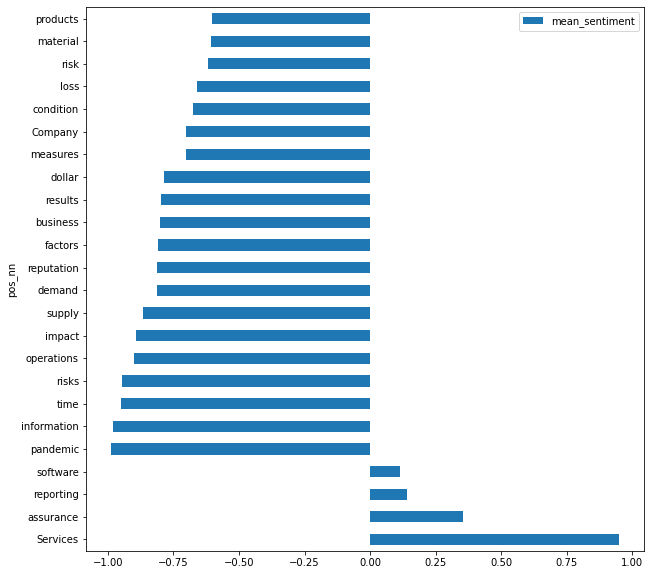

In [20]:
tmp_sent = pd.concat([sentiment_nn.query("cnt > 5").query("mean_sentiment > 0.1")\
                            .sort_values("mean_sentiment", ascending=False).head(20),
                    sentiment_nn.query("cnt > 10").query("mean_sentiment < -0.5")\
                        .sort_values("mean_sentiment").head(20)
                      ]).reset_index(drop=True)

tmp_sent[['pos_nn','mean_sentiment']].set_index('pos_nn').plot(kind='barh', 
                                                               figsize = (10,10))

# Build Question Answering system

# Retriever function - Get 1st round of potential candidates using BM25 algorithm

In [21]:
# We use BM25 as retriver which will do 1st round of candidate filtering based on word based matching

def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for doc in docs:
    tokenized_corpus.append(bm25_tokenizer(doc))

bm25 = BM25Okapi(tokenized_corpus)

In [22]:
def retrieval(query, top_k_retriver):

    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argsort(bm25_scores)[::-1][:top_k_retriver]
    bm25_hits = [{'corpus_id': idx, 
                  'score': bm25_scores[idx], 
                  'docs':docs[idx]} for idx in top_n if bm25_scores[idx] > 0]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    return bm25_hits


In [23]:
retrieval("what is the strategy?", 10)

[{'corpus_id': 339,
  'score': 8.73890252946371,
  'docs': '’s debt.. The Company’s investment policy and strategy are focused on the preservation of capital and supporting the Company’s liquidity . requirements. The Company uses a combination of internal and external management to execute its investment strategy and . achieve its investment objectives. The Company typically invests in highly rated securities, with the primary objective of . minimizing the'},
 {'corpus_id': 277,
  'score': 6.237050593283133,
  'docs': 'count-related expenses. The . Company continues to believe that focused investments in R&D are critical to its future growth and competitive position in the . marketplace, and to the development of new and updated products and services that are central to the Company’s core business . strategy.. Selling, General and Administrative. The year-over-year growth in selling, general and administrative e'}]

# QA ranker pipeline

 - Use Hugginface pipeline for QnA with roberta-base-squad2 model (https://huggingface.co/deepset/roberta-base-squad2)

In [24]:
qa_model = pipeline("question-answering", 
                    model = "deepset/roberta-base-squad2")


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [25]:

def qa_ranker(query, docs_, top_k_ranker):
    ans = []
    for doc in docs_:
        answer = qa_model(question = query, 
                            context = doc)
        answer['doc'] = doc
        ans.append(answer)
    return sorted(ans, key=lambda x: x['score'], reverse=True)[:top_k_ranker]


# Final combined pipeline

In [26]:
# Code to highlight the answer 
def print_colored(text, start_idx, end_idx):
    print(colored(text[:start_idx]) + \
          colored(text[start_idx:end_idx], 'red', 'on_yellow') + \
          colored(text[end_idx:]))

In [27]:
def final_qa_pipeline(query, top_k_retriver, top_k_ranker):
    lvl1 = retrieval(query, top_k_retriver)
    print(f"{len(lvl1)} documents retrived using BM25")
    if len(lvl1) > 0:
        fnl_rank = qa_ranker(query, [l["docs"] for l in lvl1], top_k_ranker)
        for fnl_ in fnl_rank:
            print("\n")
            print_colored(fnl_['doc'], fnl_['start'], fnl_['end'])
            print(colored("Confidence score of ") + colored(str(fnl_['score'])[:4], attrs=['bold']))
    else:
        return None

# Demo
- Use high retriever count to get more candidates
- Use small qa_ranker counts to show the most important results only

In [28]:
final_qa_pipeline("How high is shareholders equity?", 50,3)

50 documents retrived using BM25


20 Form 10-K | 32. CONSOLIDATED BALANCE SHEETS. (In millions, except number of shares which are reflected in thousands and par value). Apple Inc.. ASSETS:. LIABILITIES AND SHAREHOLDERS’ EQUITY:. $ . 323,888 $ . $ . 42,296 $ . Current assets:. Cash and cash equivalents. Marketable securities. Accounts receivable, net. Inventories. Vendor non-trade receivables. Other current assets. Total current as
Confidence score of 0.51


; 16,976,763 and 17,772,945 shares issued and outstanding, respectively . Retained earnings. Accumulated other comprehensive income/(loss). Total shareholders’ equity. 50,779 . 14,966 . (406) . 65,339 . 45,174 . 45,898 . (584) . 90,488 . Total liabilities and shareholders’ equity. $ . 323,888 $ . 338,516 . See accompanying Notes to Consolidated Financial Statements.. Apple Inc. | 2020 Form 10-K | 
Confidence score of 0.33


Apple Inc. | 2020 Form 10-K | 33. Apple Inc.. CONSOLIDATED STATEMENTS OF SHAREHOLDERS’ EQUITY. (In millions, 

In [29]:
final_qa_pipeline("what is competitors strategy?", 50,3)

15 documents retrived using BM25


ards, continual improvement in product price and performance characteristics, rapid . adoption of technological advancements by competitors, and price sensitivity on the part of consumers and businesses. Many of . the Company’s competitors seek to compete primarily through aggressive pricing and very low cost structures, and by emulating . the Company’s products and infringing on its intellectual 
Confidence score of 0.38


f the Company’s competitors seek to compete . primarily through aggressive pricing and very low cost structures, and by emulating the Company’s products and infringing on . its intellectual property. Effective intellectual property protection may not be consistently available in every country in which the . Company operates. If the Company is unable to continue to develop and sell innovative new p
Confidence score of 0.36


icularly intense as competitors have aggressively cut prices and lowered product margins. Certain . competito

In [30]:
final_qa_pipeline("what are the number of shares outstanding?", 50,3)

50 documents retrived using BM25


; 16,976,763 and 17,772,945 shares issued and outstanding, respectively . Retained earnings. Accumulated other comprehensive income/(loss). Total shareholders’ equity. 50,779 . 14,966 . (406) . 65,339 . 45,174 . 45,898 . (584) . 90,488 . Total liabilities and shareholders’ equity. $ . 323,888 $ . 338,516 . See accompanying Notes to Consolidated Financial Statements.. Apple Inc. | 2020 Form 10-K | 
Confidence score of 0.60


ares of common stock held by executive officers and directors of the Registrant as of such date have been excluded because such . persons may be deemed to be affiliates. This determination of executive officers and directors as affiliates is not necessarily a conclusive . determination for any other purposes.. 17,001,802,000 shares of common stock were issued and outstanding as of October 16, 2020
Confidence score of 0.60


 of certain events relating to . the Company’s stock contemplated by Section 11 of the Plan (including, witho

In [31]:
final_qa_pipeline("what is the priority of the company?", 50,3)

50 documents retrived using BM25


Services. Digital Content. The Company offers a portfolio of fee-based service and support products under the AppleCare® brand. The offerings provide . priority access to Apple technical support, access to the global Apple authorized service network for repair and replacement . services, and in many cases additional coverage for instances of accidental damage and/or theft and loss, depending on th
Confidence score of 0.33


iers decide to . concentrate on the production of common components instead of components customized to meet the Company’s requirements.. The Company has entered into agreements for the supply of many components; however, there can be no guarantee that the . Company will be able to extend or renew these agreements on similar terms, or at all.. Substantially all of the Company’s hardware products a
Confidence score of 0.12


to provide products and services that compete effectively.. Apple Inc. | 2020 Form 10-K | 6. To remain compet

In [32]:
final_qa_pipeline("What are the top performing products?", 50,3)

50 documents retrived using BM25


computers, tablets and other electronic devices. Therefore, many . components used by the Company, including those that are available from multiple sources, are at times subject to industry-wide . shortage and significant commodity pricing fluctuations.. The Company uses some custom components that are not commonly used by its competitors, and new products introduced by . the Company often utilize
Confidence score of 0.02


oss margin and gross margin percentage for 2020, 2019 and 2018 were as follows (dollars in millions):. Gross Margin. Gross margin:. Products. Services. Total gross margin. Gross margin percentage:. Products. Services. Total gross margin percentage. Products Gross Margin. 2020. 2019. 2018. $ . . $ . 69,461 $ . 68,887 $ . 35,495 . . 29,505 . . 77,683 . 24,156 . 104,956 $ . 98,392 $ . 101,839 . 31.5%
Confidence score of 0.01


 . 17,381 . 39,748 . Total net sales. $ . 274,515 . 6 % $ . 260,174 . (2) % $ . 265,595 . (1) Products net sa

In [33]:
final_qa_pipeline("What did company release?", 50,3)

50 documents retrived using BM25


other information filed by . the Company with the SEC are available free of charge at investor.apple.com/investor-relations/sec-filings/default.aspx when . such reports are available on the SEC’s website. The Company periodically provides other information for investors on its . corporate website, www.apple.com, and its investor relations website, investor.apple.com. This includes press releases a
Confidence score of 0.08


varying maturities for an aggregate . principal amount of $106.1 billion (collectively the “Notes”). During 2020, the Company issued $16.1 billion and repaid or . redeemed $12.6 billion of Notes. The Company has entered, and in the future may enter, into interest rate swaps to manage . interest rate risk on the Notes. In addition, the Company has entered, and in the future may enter, into foreign 
Confidence score of 0.03


t. Commercial Paper and Repurchase Agreements. The Company issues unsecured short-term promissory notes (“Com

In [34]:
final_qa_pipeline("What is company expanding into?", 50,3)

50 documents retrived using BM25


 distribution capability, service and support, and corporate reputation.. Apple Inc. | 2020 Form 10-K | 2. The Company is focused on expanding its market opportunities related to smartphones, personal computers, tablets and other . electronic devices and services. The Company faces substantial competition in these markets from companies that have . significant technical, marketing, distribution an
Confidence score of 0.22


varying maturities for an aggregate . principal amount of $106.1 billion (collectively the “Notes”). During 2020, the Company issued $16.1 billion and repaid or . redeemed $12.6 billion of Notes. The Company has entered, and in the future may enter, into interest rate swaps to manage . interest rate risk on the Notes. In addition, the Company has entered, and in the future may enter, into foreign 
Confidence score of 0.09


newal of . the Company’s agreements with these carriers or in agreements the Company enters into with new car

In [35]:
final_qa_pipeline("What is total sales?", 50,3)

50 documents retrived using BM25


tatement Line Items. 2020. 2019. Unrealized (gains)/losses on derivative instruments:. Foreign exchange contracts. Interest rate contracts. Unrealized (gains)/losses on marketable debt securities Other income/(expense), net. Total amounts reclassified from AOCI. $ . (1,627) $ . Total net sales. Total cost of sales. Other income/(expense), net. Other income/(expense), net. $ . (365) $ . (584) . (60
Confidence score of 0.53


s, debt repayments and other liquidity requirements associated with its existing operations.. Fiscal 2020 Highlights. Total net sales increased 6% or $14.3 billion during 2020 compared to 2019, primarily driven by higher net sales of Services and . Wearables, Home and Accessories. The weakness in foreign currencies had an unfavorable impact on net sales during 2020.. In April 2020, the Company ann
Confidence score of 0.40


ater than three years.. Net sales disaggregated by significant products and services for 2020, 2019 and 2018 